In [19]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_timeseries, plot_spacetime
from superfv.initial_conditions import sod_shock_tube_1d
from teyssier import riemann

In [20]:
N = 100
T = 0.245

configs = {
    "MUSCL-Hancock": dict(
        p=1,
        riemann_solver="hllc",
        flux_recipe=2,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives="adaptive",
        ZS=True,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives="full",
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "ZS7": dict(
        p=7,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives="adaptive",
        ZS=True,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM7": dict(
        p=7,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives="full",
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(ic=sod_shock_tube_1d, bcx="free", nx=N, **config)

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            snapshot_mode="every",
            muscl_hancock=config.get("MUSCL", False),
        )
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running MUSCL-Hancock...
Step #67 @ t=2.47e-01 | dt=3.63e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (ran in 0.08s)           
Running ZS3...
Step #67 @ t=2.46e-01 | dt=3.59e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (ran in 0.47s)           
Running MM3...
Step #67 @ t=2.47e-01 | dt=3.63e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (ran in 0.48s)           
Running ZS7...
Step #67 @ t=2.45e-01 | dt=3.58e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (ran in 0.46s)           
Running MM7...
Step #67 @ t=2.47e-01 | dt=3.63e-03 | min(rho)=1.25e-01, min(P)=1.00e-01 | (ran in 0.46s)           


In [21]:
# analytical solution for plotting
xana = (np.arange(1024) + 0.5) / 1024
wana = np.zeros([3, 1024])
for i in range(0, np.size(xana)):
    s = (xana[i] - 0.5) / sim.t
    d, v, p = riemann.exact_solution(s, [1, 0, 1], [0.125, 0, 0.1])
    wana[:, i] = [d, v, p]

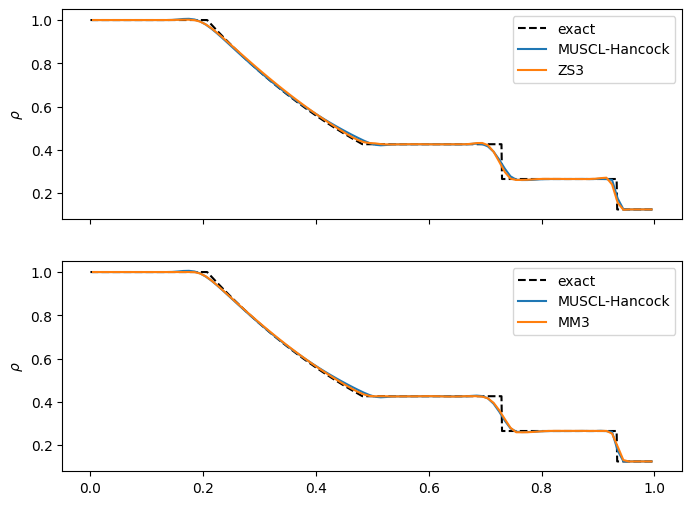

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")


sim0 = sims["MUSCL-Hancock"]
sim1 = sims["ZS3"]
sim2 = sims["ZS7"]
sim3 = sims["MM3"]
sim4 = sims["MM7"]

style = dict()

# exact
axs[0].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)
axs[1].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)

# MUSCL-Hancock
plot_1d_slice(sim0, axs[0], "rho", label="MUSCL-Hancock", **style)
plot_1d_slice(sim0, axs[1], "rho", label="MUSCL-Hancock", **style)

# ZS3 and ZS7
plot_1d_slice(sim1, axs[0], "rho", label="ZS3", **style)
# plot_1d_slice(sim2, axs[0], "rho", label="ZS7", **style)

# MM3 and MM7
plot_1d_slice(sim3, axs[1], "rho", label="MM3", **style)
# plot_1d_slice(sim4, axs[1], "rho", label="MM7", **style)

axs[0].legend()
axs[1].legend()

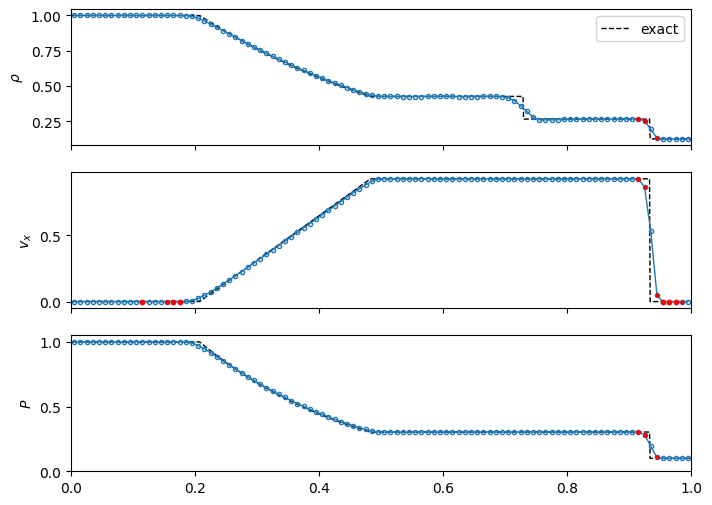

In [23]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[0].set_xlim(0, 1)
axs[2].set_ylim(0, 1.05)

style = dict(linewidth=1, markersize=3)

axs[0].plot(xana, wana[0], color="k", linestyle="--", label="exact", **style)
axs[1].plot(xana, wana[1], color="k", linestyle="--", label="exact", **style)
axs[2].plot(xana, wana[2], color="k", linestyle="--", label="exact", **style)

sim = sims["MM3"]

plot_1d_slice(sim, axs[0], "rho", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[1], "vx", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[2], "P", marker="o", mfc="none", trouble_marker="o", **style)


axs[0].legend()

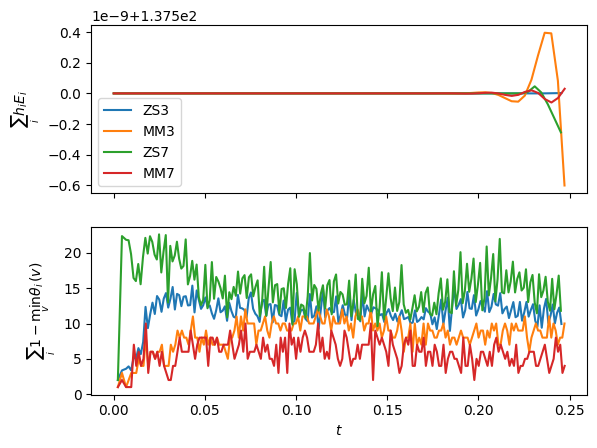

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_ylabel(r"$\sum_i h_i E_i$")
axs[1].set_ylabel(r"$\sum_i 1 - \min_v{\theta_i(v)}$")
axs[1].set_xlabel(r"$t$")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]
sim3 = sims["ZS7"]
sim4 = sims["MM7"]

plot_timeseries(sim1, axs[0], "total_E", label="ZS3")
plot_timeseries(sim2, axs[0], "total_E", label="MM3")
plot_timeseries(sim3, axs[0], "total_E", label="ZS7")
plot_timeseries(sim4, axs[0], "total_E", label="MM7")

plot_timeseries(sim1, axs[1], "nfine_1-theta_vis_max", label="ZS3")
plot_timeseries(sim2, axs[1], "nfine_troubles_vis_max", label="MM3")
plot_timeseries(sim3, axs[1], "nfine_1-theta_vis_max", label="ZS7")
plot_timeseries(sim4, axs[1], "nfine_troubles_vis_max", label="MM7")

axs[0].legend()

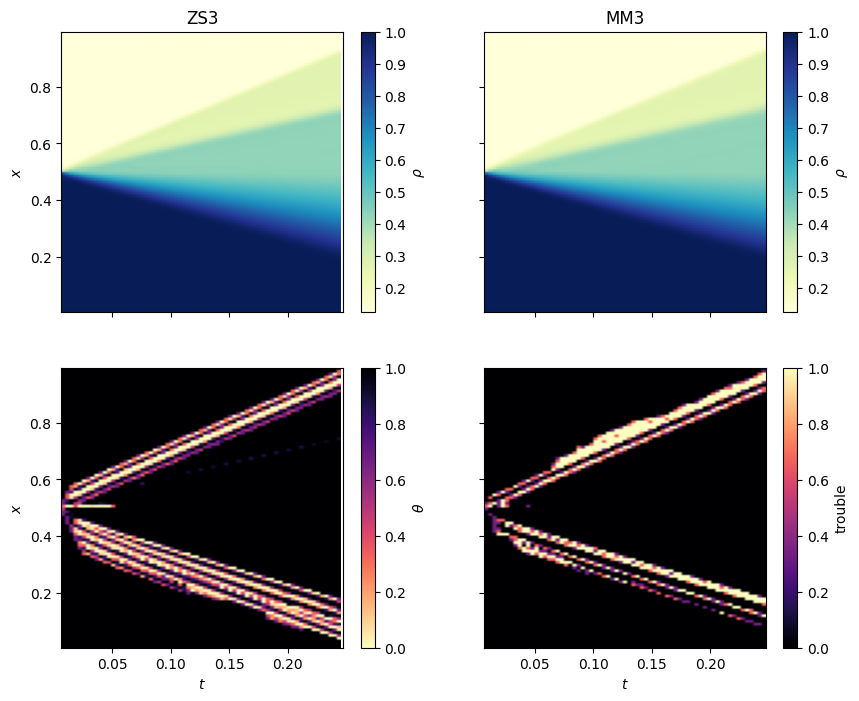

In [25]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title("ZS3")
axs[0, 1].set_title("MM3")
axs[0, 0].set_ylabel(r"$x$")
axs[1, 0].set_ylabel(r"$x$")
axs[1, 0].set_xlabel(r"$t$")
axs[1, 1].set_xlabel(r"$t$")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

rho_min = min(
    np.min(sim1.minisnapshots["min_rho"]), np.min(sim2.minisnapshots["min_rho"])
)
rho_max = max(
    np.max(sim1.minisnapshots["max_rho"]), np.max(sim2.minisnapshots["max_rho"])
)

rho_style = dict(
    cell_averaged=True, colorbar=True, vmin=rho_min, vmax=rho_max, cmap="YlGnBu"
)
_, cbar0 = plot_spacetime(sim1, axs[0, 0], "rho", **rho_style)
_, cbar1 = plot_spacetime(sim2, axs[0, 1], "rho", **rho_style)
cbar0.set_label(r"$\rho$")
cbar1.set_label(r"$\rho$")

trouble_style = dict(colorbar=True, vmin=0, vmax=1)
_, cbar2 = plot_spacetime(
    sim1, axs[1, 0], "min", theta=True, cmap="magma_r", **trouble_style
)
_, cbar3 = plot_spacetime(
    sim2, axs[1, 1], "max", troubles=True, cmap="magma", **trouble_style
)
cbar2.set_label(r"$\theta$")
cbar3.set_label("trouble")

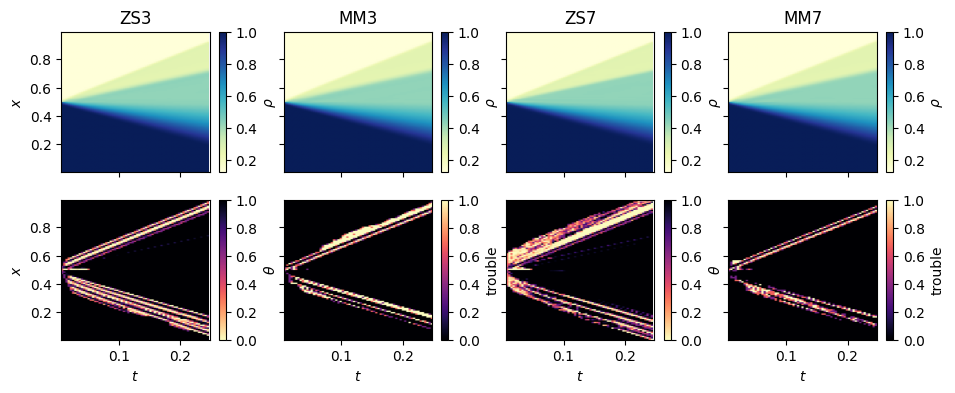

In [30]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11, 4))
axs[0, 0].set_title("ZS3")
axs[0, 1].set_title("MM3")
axs[0, 2].set_title("ZS7")
axs[0, 3].set_title("MM7")
[axs[i, 0].set_ylabel(r"$x$") for i in (0, 1)]
[axs[1, j].set_xlabel(r"$t$") for j in [0, 1, 2, 3]]

sim1 = sims["ZS3"]
sim2 = sims["MM3"]
sim3 = sims["ZS7"]
sim4 = sims["MM7"]

rho_min = min(np.min(sim.minisnapshots["min_rho"]) for sim in [sim1, sim2, sim3, sim4])
rho_max = max(np.max(sim.minisnapshots["max_rho"]) for sim in [sim1, sim2, sim3, sim4])

rho_style = dict(
    cell_averaged=True, colorbar=True, vmin=rho_min, vmax=rho_max, cmap="YlGnBu"
)
for j, sim in enumerate([sim1, sim2, sim3, sim4]):
    _, cbar = plot_spacetime(sim, axs[0, j], "rho", **rho_style)
    cbar.set_label(r"$\rho$")

trouble_style = dict(colorbar=True, vmin=0, vmax=1)
for j, sim in zip([0, 2], [sim1, sim3]):
    _, cbar = plot_spacetime(
        sim, axs[1, j], "min", theta=True, cmap="magma_r", **trouble_style
    )
    cbar.set_label(r"$\theta$")
for j, sim in zip([1, 3], [sim2, sim4]):
    _, cbar = plot_spacetime(
        sim, axs[1, j], "max", troubles=True, cmap="magma", **trouble_style
    )
    cbar.set_label("trouble")